In [34]:
import os, sys, time, datetime, random
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision.utils import draw_bounding_boxes
import ast
from torchvision.io import read_image
import torchvision.transforms.functional as F
from torchvision.transforms.functional import convert_image_dtype
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [35]:
file = open('../../data/imagenet_classes.txt', 'r')
labels = ast.literal_eval(file.read())
file = open('../../data/imagenet-a/README.txt', 'r')
lines = file.readlines()
class_mappings = {}
for l in lines[12:-1]:
#     print(l.replace(' \n', '')[:9], l.replace(' \n', '')[10:])
    cls_nbr, cls_name = l.replace(' \n', '')[:9], l.replace(' \n', '')[10:]
    class_mappings[cls_nbr] = cls_name
    
image_paths = {c: [] for c in class_mappings.values()}
for root, directory, files in os.walk('../../data/imagenet-a'):
    for file in files:
        if '.jpg' in file:
            image_paths[class_mappings[root.split('/')[-1]]].append(root+'/'+file)

Class: sleeping bag 	 Choice = 0 	 Imagenet class = 797


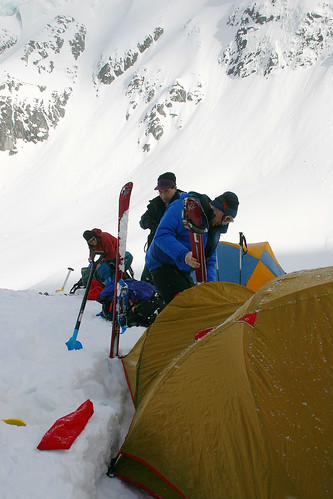

In [36]:
def show_random_image(class_name = None, choice=None, verbose=True):
    if not class_name:
        class_name = random.choice(list(class_mappings.values()))
    if not choice:
        choice = random.choice(range(len(image_paths[class_name])))
    try:
        img_cls = [i for i in range(len(labels)) if class_name.lower() in labels[i].lower()][0]
    except:
        print(class_name)
    if verbose:
        print(f"Class: {class_name} \t Choice = {choice} \t Imagenet class = {img_cls}")
    return img_cls, class_name, choice, Image.open(image_paths[class_name][choice])

img_cls, class_name, choice, image = show_random_image()
image

In [49]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocessing = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean, std)])


def get_displ_img(img):
    try:
        img = img.cpu().numpy().transpose((1, 2, 0))
    except:
        img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    displ_img = std * img + mean
    displ_img = np.clip(displ_img, 0, 1)
    displ_img /= np.max(displ_img)
    displ_img = displ_img
    displ_img = np.uint8(displ_img*255)
    return displ_img/np.max(displ_img)

model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
model.eval()

dog_int = read_image(image_paths['snowplow'][6])

batch_int = torch.stack([dog_int])

batch = convert_image_dtype(batch_int, dtype=torch.float)

# img_cls, class_name, choice, image = show_random_image(class_name, choice)
# batch_int = torch.unsqueeze(preprocessing(image),0)
outputs = model(batch)
# print(outputs)

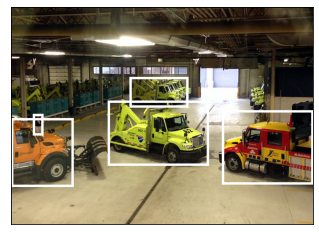

In [50]:
score_threshold = .9
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for dog_int, output in zip(batch_int, outputs)
]
show(dogs_with_boxes)